In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import telegram
import pandahouse
from datetime import date, timedelta
import datetime
import io
import sys
import os
import numpy as np
import scipy.stats as stats
import random

In [2]:
connection = {
    'host': 'http://clickhouse.address',
    'password': 'pass',
    'user': 'name',
    'database': 'simulator'
    }


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220520.feed_actions 
WHERE toDate(time) between '2022-04-17' and '2022-04-23'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

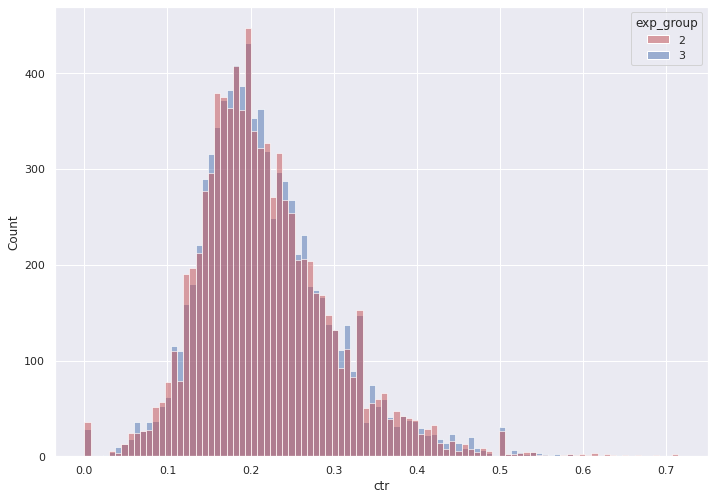

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Невооруженным глазом видно, что группы очень похожи

In [8]:
print(stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False))
print('Статистически значимое отличие отсутствует.')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample(500).values[0] > df[df.exp_group == 3].ctr.sample(500).values[0]
    
print('В', A_gt_B/100, '% случаев A > B')

Ttest_indResult(statistic=-0.739359792495814, pvalue=0.45969873156477636)
Статистически значимое отличие отсутствует.
В 48.12 % случаев A > B


Если группы статистически равны, мы получим около 50% - что у нас и выходит раз за разом при проведении сравнения. <br> Теперь проведем 10000 экспериментов со сравнением данных t-теста

In [9]:
exp_AA = []
for _ in range(10000):
    exp_AA.append(stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500),
                df[df.exp_group == 3].ctr.sample(500),
                equal_var=False).pvalue)

Провели 10000 экспериментов из подвыборки в 500 значений переменных, сравнили t-тестом, и сохранили в переменную эти 10000 p-значений

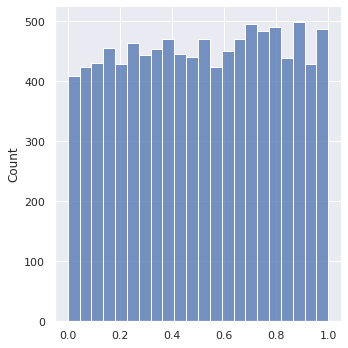

In [6]:
sns.displot(exp_AA)

Видим примерно равномерное распределением по всему диапозону от 0 до 1. Это говорит о том, что попадание p-значения в разные точки это диапазона примерно равновероятны

In [7]:
p_exp = []
for i in exp_AA:
    if i < 0.05:
        p_exp.append(i)
len(p_exp) / len(exp_AA)

0.045

Количество p-значений из 10000 экспериментов, не превышающих 0.05, не превышает уровень 0.05: вероятность попадания значения в диапазон равновероятны и АА тесты говорят о том, что, что данные засплитованы корректно